Load the libraries required for logistic regression

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

load the data stored in the path specified

In [2]:
df = pd.read_table('/Users/subasrees/Desktop/Omics-analysis/intro-machine-learning-training/exam/heartData_simplified.csv',sep=',')
df.head()

,age,sex,chol,thalach,oldpeak,ca,thal,target
0,63,male,233,150,2.3,0,defect,no
1,37,male,250,187,3.5,0,normal,no
2,41,female,204,172,1.4,0,normal,no
3,56,male,236,178,0.8,0,normal,no
4,57,female,354,163,0.6,0,normal,no


In [3]:
df['thal'] = df['thal'].astype(pd.CategoricalDtype(categories=["normal", "reversible", "defect"],ordered=True))

# get dummies will transform these categorical columns to sets of 0/1 columns
df = pd.get_dummies( df , drop_first=True )

df.head()

,age,chol,thalach,oldpeak,ca,sex_male,thal_reversible,thal_defect,target_yes
0,63,233,150,2.3,0,True,False,True,False
1,37,250,187,3.5,0,True,False,False,False
2,41,204,172,1.4,0,False,False,False,False
3,56,236,178,0.8,0,True,False,False,False
4,57,354,163,0.6,0,False,False,False,False


Specify the features and the response

In [4]:
X_diabetes=df.iloc[:,:len(df.columns)-1]
y_diabetes=df.target_yes

Select the training and test data

In [5]:
from sklearn.model_selection import train_test_split

#default if 75% training, 25% testing
X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(X_diabetes, 
                                                                                y_diabetes,
                                                                                random_state=7,
                                                                                stratify=y_diabetes) 

print("number of samples:")
print( f"\tfull  dataset: {len(y_diabetes)}" )
print( f"\ttrain dataset: {len(y_diabetes_train)}" )
print( f"\ttest  dataset: {len(y_diabetes_test)}" )


# train_test_split stratify make sure to split the data such 
# that the two partitions have similar proportion of each target classes
print("\nproportion of diabtes:")
print( f"\tfull  dataset: {y_diabetes.mean():.3f}" )
print( f"\ttrain dataset: {y_diabetes_train.mean():.3f}" )
print( f"\ttest  dataset: {y_diabetes_test.mean():.3f}" )



number of samples:
	full  dataset: 296
	train dataset: 222
	test  dataset: 74

proportion of diabtes:
	full  dataset: 0.459
	train dataset: 0.459
	test  dataset: 0.459


In [6]:
## first we split in train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes_train, 
                                                      y_diabetes_train,
                                                      random_state=13245,
                                                      test_size=0.3,
                                                      stratify=y_diabetes_train) 

## scaling 
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_valid_norm = scaler.fit_transform(X_valid)

In [7]:
feature_names = list( df.columns) [:-1]

logCs = []

coef_dict = {'name' : [],
             'val' : [],
             'log_C' : []}
accuracies = []

for C in np.logspace(-3,2,100):

    lr = LogisticRegression( penalty = 'l2' , C = C  , solver='liblinear',class_weight='balanced')
    lr.fit(X_train_norm , y_train)
    
    logCs.append(np.log10(C))
    accuracies.append( accuracy_score( y_valid , lr.predict(X_valid_norm) ) )
    
    coef_dict['name'] += list( feature_names )
    coef_dict['val'] += list( lr.coef_[0] )
    coef_dict['log_C'] += [np.log10(C)]* len(feature_names )

coef_df = pd.DataFrame(coef_dict)

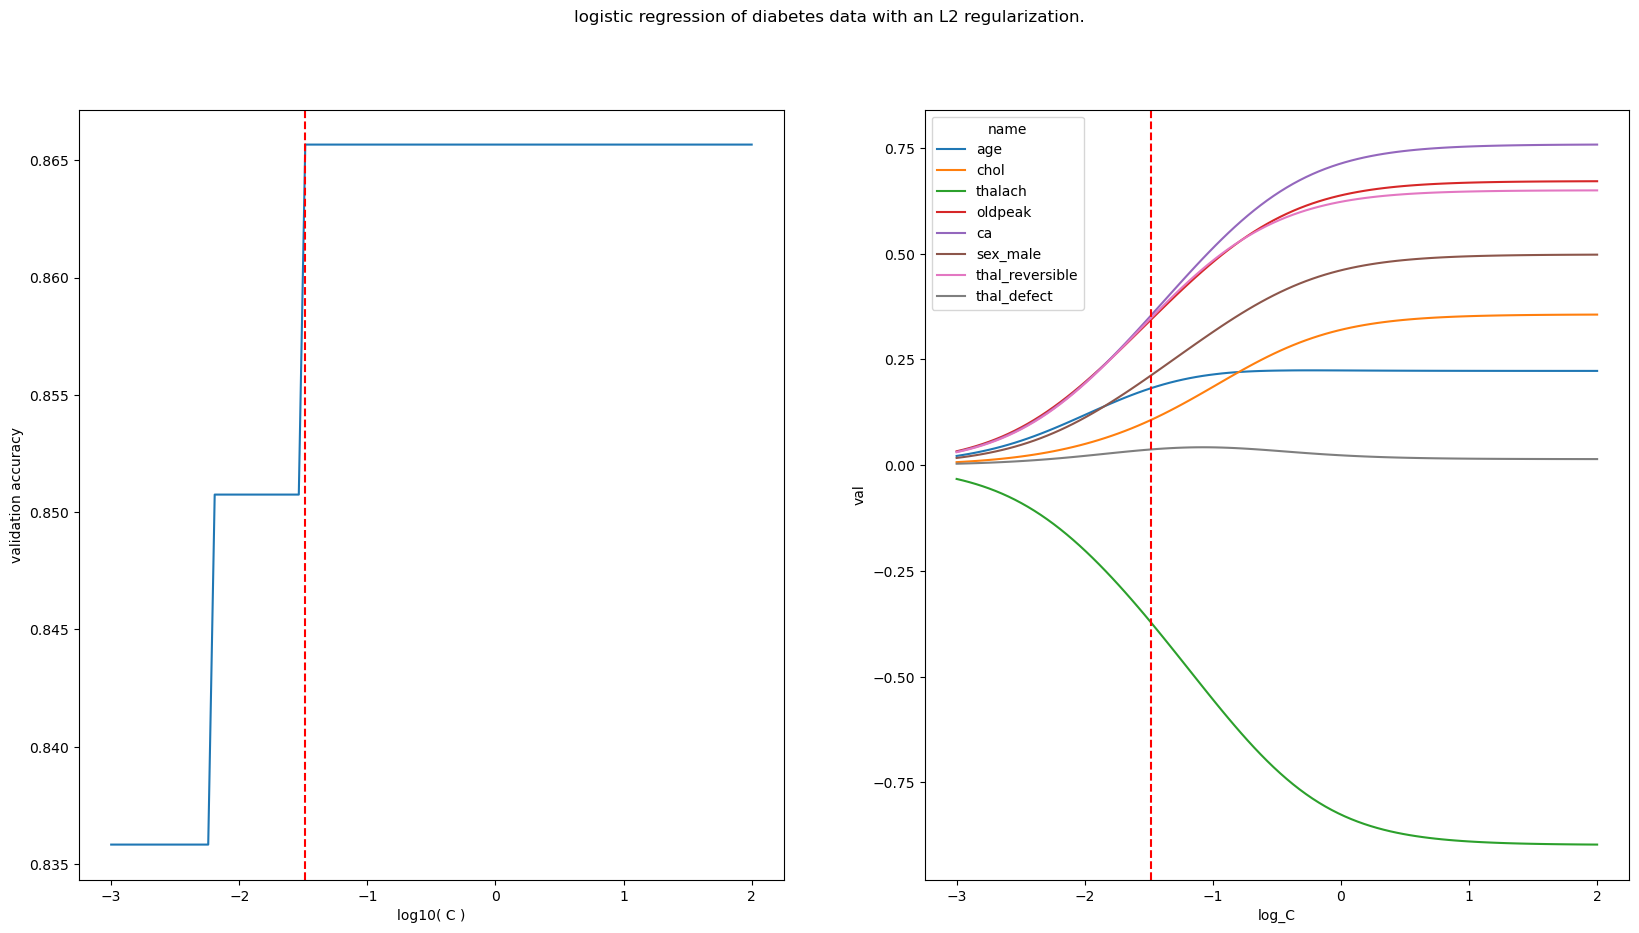

In [8]:
bestC = logCs[ np.argmax( accuracies ) ]

fig,ax = plt.subplots(1,2,figsize = (20,10))

ax[0].plot(logCs , accuracies)
ax[0].set_xlabel("log10( C )")
ax[0].set_ylabel("validation accuracy")
ax[0].axvline( bestC, color='r', ls = '--' )

sns.lineplot( x = 'log_C' , y='val' , hue = 'name' , data= coef_df , ax = ax[1])
ax[1].axvline( bestC , color='r', ls = '--' )

fig.suptitle("logistic regression of diabetes data with an L2 regularization.")
plt.show()

In [9]:
logi_r=LogisticRegression(solver='liblinear',n_jobs=1) 
pipeline_lr=Pipeline([('scalar',StandardScaler()), 
                      ('model',logi_r)])



grid_values = {'model__C': np.logspace(-5,2,200),
               'model__penalty': ['l1','l2'] }

grid_lr_acc = GridSearchCV(pipeline_lr, 
                           param_grid = grid_values, 
                           scoring='accuracy',
                           cv=10, 
                           n_jobs=-1)

grid_lr_acc.fit(X_diabetes_train, y_diabetes_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        LogisticRegression(n_jobs=1,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00000000e-05, 1.08436597e-05, 1.17584955e-05, 1.27505124e-05,
       1.38262217e-05, 1.49926843e-05, 1.62575567e-05, 1.76291412e-05,
       1.91164408e-05, 2.07292178e-05, 2.24780583e-05, 2.43744415e-...
       2.14614120e+01, 2.32720248e+01, 2.52353917e+01, 2.73644000e+01,
       2.96730241e+01, 3.21764175e+01, 3.48910121e+01, 3.78346262e+01,
       4.10265811e+01, 4.44878283e+01, 4.82410870e+01, 5.23109931e+01,
       5.67242607e+01, 6.15098579e+01, 6.66991966e+01, 7.23263390e+01,
       7.84282206e+01, 8.50448934e+01, 9.22197882e+01, 1.00000000e+02]),
                         'model__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [10]:
print('Grid best parameter (max. accuracy): ', grid_lr_acc.best_params_)#get the best parameters
print('Grid best score (cross-validated accuracy): {:.4f}'.format( grid_lr_acc.best_score_ ) )

Grid best parameter (max. accuracy):  {'model__C': 0.00651733960488242, 'model__penalty': 'l2'}
Grid best score (cross-validated accuracy): 0.8466


In [11]:
from operator import itemgetter
lr = grid_lr_acc.best_estimator_[1]
w=lr.coef_[0]#get the weights

featureW = pd.DataFrame( {'feature':df.columns[:-1],'weight':w} )

featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
print( featureWsorted.loc[ featureWsorted["weight"] !=0 ] )


Features sorted per importance:
           feature    weight
2          thalach -0.215178
6  thal_reversible  0.210872
3          oldpeak  0.185098
4               ca  0.177094
5         sex_male  0.110559
0              age  0.081891
1             chol  0.044753
7      thal_defect  0.039203


Text(0.5, 14.722222222222216, 'Predicted label')

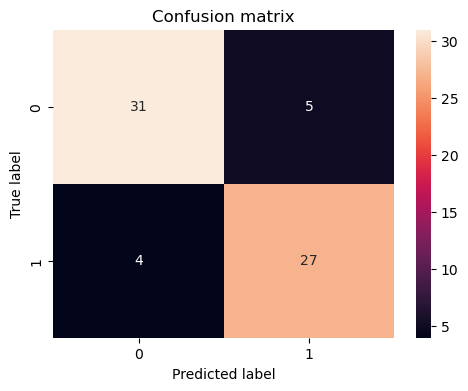

In [12]:
from sklearn.metrics import precision_score
from matplotlib import gridspec
from sklearn.metrics import accuracy_score, confusion_matrix

## confusion matrix
y_pred = lr.predict(X_valid_norm)
confusion_diabetes = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(5.5,4))
sns.heatmap(confusion_diabetes, annot=True)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Removing the last three features which contribute less to the response 

In [13]:
df_diabetes_remove=df.drop(['age','chol','thal_defect'],axis=1)

Assign the features and the response

In [14]:
X_diabetes_remove=df_diabetes_remove.iloc[:,:len(df_diabetes_remove.columns)-1]
y_diabetes_remove=df_diabetes_remove.target_yes

In [15]:
from sklearn.model_selection import train_test_split

#default if 75% training, 25% testing
X_diabetes_train_remove, X_diabetes_test_remove, y_diabetes_train_remove, y_diabetes_test_remove, = train_test_split(X_diabetes_remove, 
                                                                                y_diabetes_remove,
                                                                                random_state=7,
                                                                                stratify=y_diabetes_remove) 

print("number of samples:")
print( f"\tfull  dataset: {len(y_diabetes_remove)}" )
print( f"\ttrain dataset: {len(y_diabetes_train_remove)}" )
print( f"\ttest  dataset: {len(y_diabetes_test_remove,)}" )
print("\nproportion of diabtes:")
print( f"\tfull  dataset: {y_diabetes_remove.mean():.3f}" )
print( f"\ttrain dataset: {y_diabetes_train_remove.mean():.3f}" )
print( f"\ttest  dataset: {y_diabetes_test_remove.mean():.3f}" )



number of samples:
	full  dataset: 296
	train dataset: 222
	test  dataset: 74

proportion of diabtes:
	full  dataset: 0.459
	train dataset: 0.459
	test  dataset: 0.459


In [16]:
## first we split in train and valid
X_train_remove, X_valid_remove, y_train_remove, y_valid_remove = train_test_split(X_diabetes_remove, 
                                                      y_diabetes_remove,
                                                      random_state=13245,
                                                      test_size=0.3,
                                                      stratify=y_diabetes_remove) 

## scaling 
scaler = StandardScaler()
X_train_norm_remove = scaler.fit_transform(X_train_remove)
X_valid_norm_remove = scaler.fit_transform(X_valid_remove)

In [17]:
feature_names = list( df_diabetes_remove.columns)[:-1]
print(feature_names)

logCs = []

coef_dict = {'name' : [],
             'val' : [],
             'log_C' : []}
accuracies = []

for C in np.logspace(-3,2,100):

    lr = LogisticRegression( penalty = 'l2' , C = C  , solver='liblinear',class_weight='balanced')
    lr.fit(X_train_norm_remove , y_train_remove)
    
    logCs.append(np.log10(C))
    accuracies.append( accuracy_score( y_valid_remove , lr.predict(X_valid_norm_remove) ) )
    
    coef_dict['name'] += list( feature_names )
    coef_dict['val'] += list( lr.coef_[0] )
    coef_dict['log_C'] += [np.log10(C)]* len(feature_names )

coef_df = pd.DataFrame(coef_dict)

['thalach', 'oldpeak', 'ca', 'sex_male', 'thal_reversible']


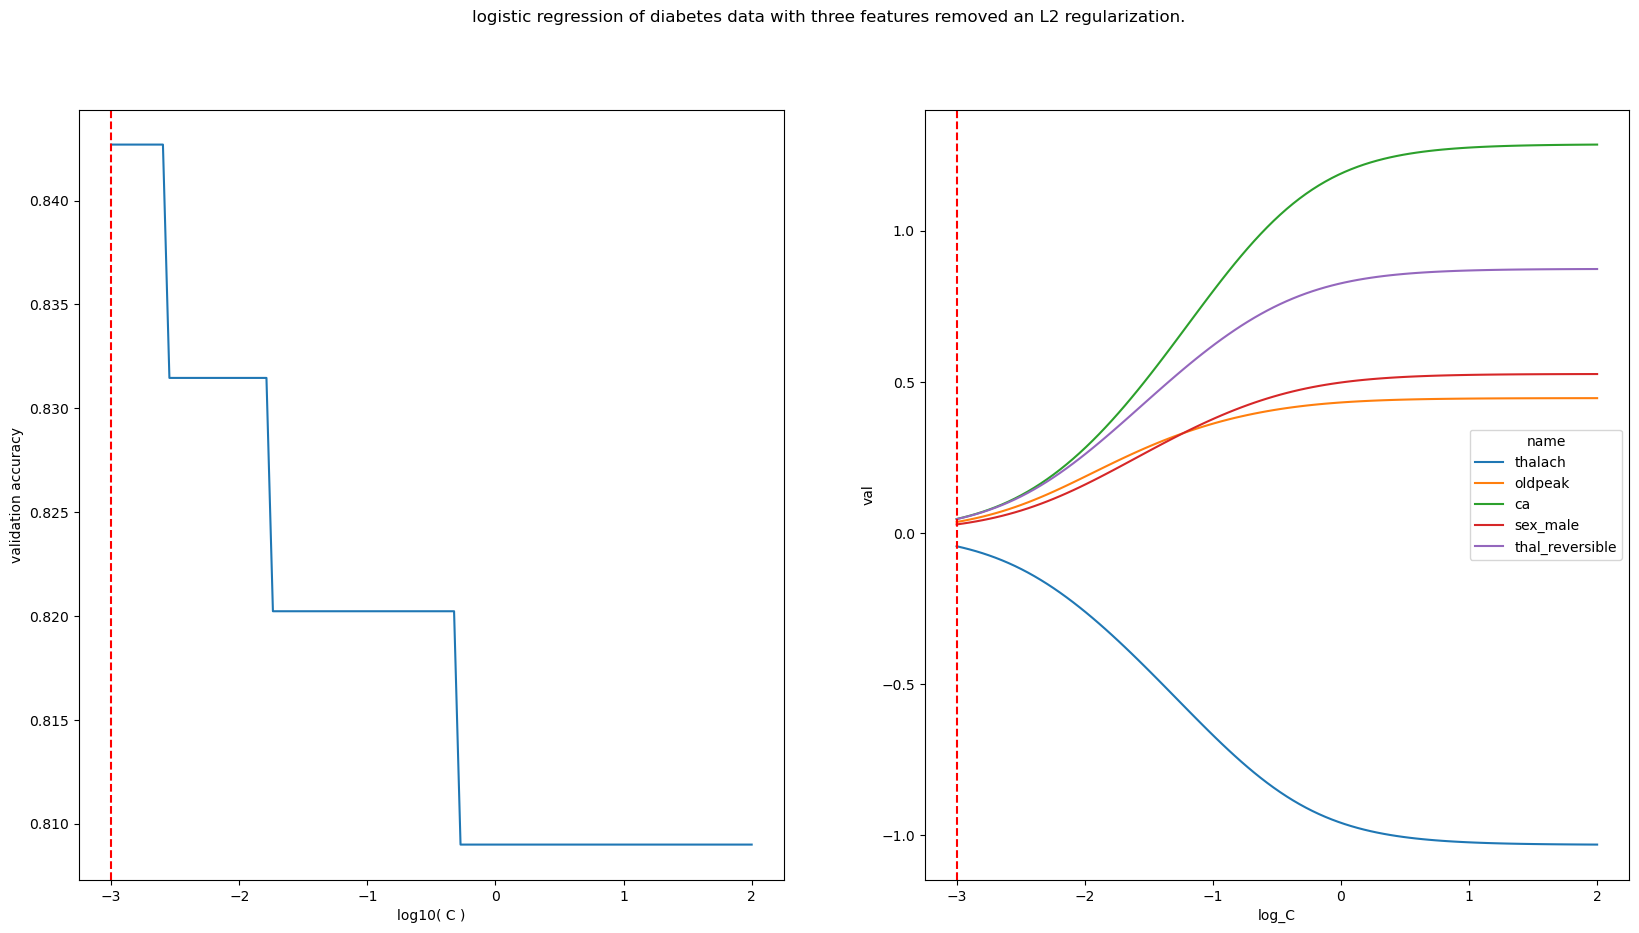

In [18]:
bestC = logCs[ np.argmax( accuracies ) ]

fig,ax = plt.subplots(1,2,figsize = (20,10))

ax[0].plot(logCs , accuracies)
ax[0].set_xlabel("log10( C )")
ax[0].set_ylabel("validation accuracy")
ax[0].axvline( bestC, color='r', ls = '--' )

sns.lineplot( x = 'log_C' , y='val' , hue = 'name' , data= coef_df , ax = ax[1])
ax[1].axvline( bestC , color='r', ls = '--' )

fig.suptitle("logistic regression of diabetes data with three features removed an L2 regularization.")
plt.show()

In [19]:
feature_names = list( df_diabetes_remove.columns) [:-1]

logCs = []

coef_dict = {'name' : [],
             'val' : [],
             'log_C' : []}
accuracies = []

for C in np.logspace(-3,2,100):

    lr = LogisticRegression( penalty = 'l1' , C = C  , solver='liblinear',class_weight='balanced')
    lr.fit(X_train_norm_remove , y_train_remove)
    
    logCs.append(np.log10(C))
    accuracies.append( accuracy_score( y_valid_remove , lr.predict(X_valid_norm_remove) ) )
    
    coef_dict['name'] += list( feature_names )
    coef_dict['val'] += list( lr.coef_[0] )
    coef_dict['log_C'] += [np.log10(C)]* len(feature_names )

coef_df = pd.DataFrame(coef_dict)

In [20]:
logi_r=LogisticRegression(solver='liblinear',n_jobs=1) 
pipeline_lr=Pipeline([('scalar',StandardScaler()), 
                      ('model',logi_r)])



grid_values = {'model__C': np.logspace(-5,2,200),
               'model__penalty': ['l1','l2'] }


grid_lr_acc = GridSearchCV(pipeline_lr, 
                           param_grid = grid_values, 
                           scoring='accuracy',
                           cv=10, 
                           n_jobs=-1)


grid_lr_acc.fit(X_train_remove, y_train_remove)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        LogisticRegression(n_jobs=1,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00000000e-05, 1.08436597e-05, 1.17584955e-05, 1.27505124e-05,
       1.38262217e-05, 1.49926843e-05, 1.62575567e-05, 1.76291412e-05,
       1.91164408e-05, 2.07292178e-05, 2.24780583e-05, 2.43744415e-...
       2.14614120e+01, 2.32720248e+01, 2.52353917e+01, 2.73644000e+01,
       2.96730241e+01, 3.21764175e+01, 3.48910121e+01, 3.78346262e+01,
       4.10265811e+01, 4.44878283e+01, 4.82410870e+01, 5.23109931e+01,
       5.67242607e+01, 6.15098579e+01, 6.66991966e+01, 7.23263390e+01,
       7.84282206e+01, 8.50448934e+01, 9.22197882e+01, 1.00000000e+02]),
                         'model__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [21]:
print('Grid best parameter (max. accuracy): ', grid_lr_acc.best_params_)#get the best parameters
print('Grid best score (cross-validated accuracy): {:.4f}'.format( grid_lr_acc.best_score_ ) )

Grid best parameter (max. accuracy):  {'model__C': 1e-05, 'model__penalty': 'l2'}
Grid best score (cross-validated accuracy): 0.8160


In [22]:
from operator import itemgetter
lr = grid_lr_acc.best_estimator_[1]
w=lr.coef_[0]#get the weights

featureW = pd.DataFrame( {'feature':df_diabetes_remove.columns[:-1],'weight':w} )

featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
print( featureWsorted.loc[ featureWsorted["weight"] !=0 ] )


Features sorted per importance:
           feature    weight
4  thal_reversible  0.000490
2               ca  0.000489
0          thalach -0.000488
1          oldpeak  0.000393
3         sex_male  0.000298


Text(0.5, 14.722222222222216, 'Predicted label')

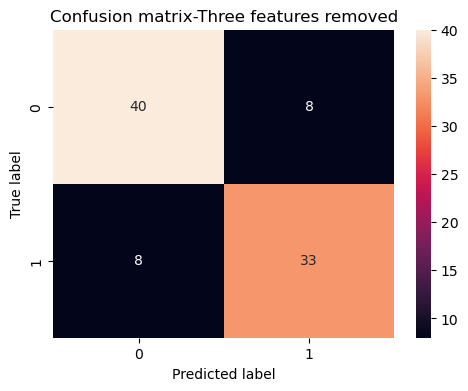

In [23]:
from sklearn.metrics import precision_score
from matplotlib import gridspec
from sklearn.metrics import accuracy_score, confusion_matrix

## confusion matrix
y_pred_remove = lr.predict(X_valid_norm_remove)
confusion_diabetes = confusion_matrix(y_valid_remove, y_pred_remove)

plt.figure(figsize=(5.5,4))
sns.heatmap(confusion_diabetes, annot=True)
plt.title('Confusion matrix-Three features removed')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Conclusions
1. The logistic regression did not yield a satisfactory prediction (~0.85)
2. Removing the three features which had very less weights did not improve the accuracy, it worsened the relationship between the features and the response
3. Both the datasets are better with L2 regularisation 